Este artigo científico aborda o crescente problema do spam por SMS, destacando a escassez de conjuntos de dados públicos para pesquisa e avaliação de filtros. Para superar essa limitação, os autores apresentam uma nova e extensa coleção de mensagens SMS reais e não codificadas, considerada a maior disponível até então. O estudo também compara o desempenho de diversos métodos de aprendizado de máquina na filtragem de spam, revelando que o Support Vector Machine (SVM) obteve os melhores resultados, estabelecendo uma importante linha de base para futuras comparações. A pesquisa conclui que, apesar dos desafios inerentes à natureza concisa e informal das mensagens SMS, o SVM demonstra ser uma técnica promissora para combater o spam móvel.

# Passo 1: Carregamento e Exploração

In [3]:
# Importando as bibliotecas
import requests
import zipfile
import io
import pandas as pd

##### Importar o dataset (disponível no link do UCI)

In [6]:
# Carregando o dataset 
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
response = requests.get(url)
response.raise_for_status() # Lança uma exceção se o download falhar

In [8]:
#descompactando os arquivos
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(".") # Extrai todos os arquivos para o diretório atual

In [10]:
df_sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

In [12]:
df_sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##### Analisar a distribuição das classes (ham vs. spam)

In [15]:
# Analisando a distribuição ham/spam
print(df_sms['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [17]:
# Exemplos de cada classe
print("\nExemplo de Ham:")
print(df_sms[df_sms['label'] == 'ham']['message'].iloc[0])
print("\nExemplo de Spam:")
print(df_sms[df_sms['label'] == 'spam']['message'].iloc[0])


Exemplo de Ham:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Exemplo de Spam:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


# Passo 2: Pré-processamento

##### Limpar o texto: remover caracteres especiais, números e converter para minúsculas. 

In [21]:
import re

def limpar_texto(texto):
    texto = re.sub(r'[^a-zA-Z]', ' ', texto)  # Remove caracteres especiais e números
    texto = texto.lower()  # Converte para minúsculas
    texto = texto.strip()  # Remove espaços em branco extras
    return texto

def analisar_texto(texto):
    """
    Remove caracteres especiais e números, converte para minúsculas, remove espaços extras
    e conta a quantidade de caracteres especiais removidos.

    Args:
        texto (str): O texto a ser analisado.

    Returns:
        tuple: Uma tupla contendo o texto limpo e a contagem de caracteres especiais removidos.
    """
    caracteres_especiais = re.findall(r'[^a-zA-Z0-9\s]', texto)
    texto_limpo = re.sub(r'[^a-zA-Z\s]', '', texto)
    texto_limpo = texto_limpo.lower()
    texto_limpo = texto_limpo.strip()
    return texto_limpo, len(caracteres_especiais)


# Aplicando a função de análise na coluna 'message'
df_sms[['message_limpo', 'qtd_caracteres_especiais']] = df_sms['message'].apply(analisar_texto).tolist()

print(df_sms)


     label                                            message  \
0      ham  Go until jurong point, crazy.. Available only ...   
1      ham                      Ok lar... Joking wif u oni...   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3      ham  U dun say so early hor... U c already then say...   
4      ham  Nah I don't think he goes to usf, he lives aro...   
...    ...                                                ...   
5567  spam  This is the 2nd time we have tried 2 contact u...   
5568   ham               Will ü b going to esplanade fr home?   
5569   ham  Pity, * was in mood for that. So...any other s...   
5570   ham  The guy did some bitching but I acted like i'd...   
5571   ham                         Rofl. Its true to its name   

                                          message_limpo  \
0     go until jurong point crazy available only in ...   
1                               ok lar joking wif u oni   
2     free entry in  a wkly comp to win fa

##### Tokenizar as mensagens (dividir em palavras ou termos). 

In [24]:
# Tokenização (exemplo com split simples)
df_sms['tokens'] = df_sms['message_limpo'].apply(lambda x: x.split())

df_sms['message'] = df_sms['message'].apply(limpar_texto)

# Tokenização (exemplo com split simples)
df_sms['tokens'] = df_sms['message'].apply(lambda x: x.split())

print(df_sms)

     label                                            message  \
0      ham  go until jurong point  crazy   available only ...   
1      ham                         ok lar    joking wif u oni   
2     spam  free entry in   a wkly comp to win fa cup fina...   
3      ham     u dun say so early hor    u c already then say   
4      ham  nah i don t think he goes to usf  he lives aro...   
...    ...                                                ...   
5567  spam  this is the  nd time we have tried   contact u...   
5568   ham                will   b going to esplanade fr home   
5569   ham  pity    was in mood for that  so   any other s...   
5570   ham  the guy did some bitching but i acted like i d...   
5571   ham                         rofl  its true to its name   

                                          message_limpo  \
0     go until jurong point crazy available only in ...   
1                               ok lar joking wif u oni   
2     free entry in  a wkly comp to win fa

In [26]:
##### Testar técnicas como remoção de stopwords ou stemming, mas observar se melhoram a precisão

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Download dos recursos necessários do NLTK (execute apenas uma vez)
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
try:
    PorterStemmer()
except LookupError:
    nltk.download('punkt')

# 1. Remoção de Stopwords
stop_words = set(stopwords.words('portuguese'))
df_sms['tokens_sem_stopwords'] = df_sms['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# 2. Stemming
porter = PorterStemmer()
df_sms['tokens_stemmed'] = df_sms['tokens_sem_stopwords'].apply(lambda tokens: [porter.stem(word) for word in tokens])

print("\nDataFrame após remoção de stopwords e stemming:")
print(df_sms[['message', 'tokens', 'tokens_sem_stopwords', 'tokens_stemmed']].head())




DataFrame após remoção de stopwords e stemming:
                                             message  \
0  go until jurong point  crazy   available only ...   
1                         ok lar    joking wif u oni   
2  free entry in   a wkly comp to win fa cup fina...   
3     u dun say so early hor    u c already then say   
4  nah i don t think he goes to usf  he lives aro...   

                                              tokens  \
0  [go, until, jurong, point, crazy, available, o...   
1                     [ok, lar, joking, wif, u, oni]   
2  [free, entry, in, a, wkly, comp, to, win, fa, ...   
3  [u, dun, say, so, early, hor, u, c, already, t...   
4  [nah, i, don, t, think, he, goes, to, usf, he,...   

                                tokens_sem_stopwords  \
0  [go, until, jurong, point, crazy, available, o...   
1                     [ok, lar, joking, wif, u, oni]   
2  [free, entry, in, wkly, comp, to, win, fa, cup...   
3  [u, dun, say, so, early, hor, u, c, already, t... 

# Passo 3: Vetorização dos Dados

##### Converter texto em features numéricas usando TF-IDF ou Bag of Words.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assume que o DataFrame df_sms com as colunas 'label' (variável alvo),
# 'tokens', 'tokens_sem_stopwords' e 'tokens_stemmed' já existem.

# Definindo a variável alvo (assumindo que a coluna se chama 'label')
y = df_sms['label']

# Função para juntar os tokens de volta em texto
def join_tokens(tokens):
    return " ".join(tokens)

# Criar representações textuais para os diferentes conjuntos de tokens
df_sms['texto_original'] = df_sms['tokens'].apply(join_tokens)
df_sms['texto_sem_stopwords'] = df_sms['tokens_sem_stopwords'].apply(join_tokens)
df_sms['texto_stemmed'] = df_sms['tokens_stemmed'].apply(join_tokens)

# --- Vetorização com TF-IDF ---

# 1. Texto Original
tfidf_orig = TfidfVectorizer()
X_orig_tfidf = tfidf_orig.fit_transform(df_sms['texto_original'])
X_train_orig_tfidf, X_test_orig_tfidf, y_train_orig, y_test_orig = train_test_split(
    X_orig_tfidf, y, test_size=0.2, random_state=42
)

# 2. Texto sem Stopwords
tfidf_sw = TfidfVectorizer()
X_sw_tfidf = tfidf_sw.fit_transform(df_sms['texto_sem_stopwords'])
X_train_sw_tfidf, X_test_sw_tfidf, y_train_sw, y_test_sw = train_test_split(
    X_sw_tfidf, y, test_size=0.2, random_state=42
)

# 3. Texto com Stemming
tfidf_stem = TfidfVectorizer()
X_stem_tfidf = tfidf_stem.fit_transform(df_sms['texto_stemmed'])
X_train_stem_tfidf, X_test_stem_tfidf, y_train_stem, y_test_stem = train_test_split(
    X_stem_tfidf, y, test_size=0.2, random_state=42
)

print("Dados vetorizados com TF-IDF:")
print("Shape do texto original (TF-IDF):", X_orig_tfidf.shape)
print("Shape do texto sem stopwords (TF-IDF):", X_sw_tfidf.shape)
print("Shape do texto com stemming (TF-IDF):", X_stem_tfidf.shape)

# --- Vetorização com Bag of Words (CountVectorizer) ---

from sklearn.feature_extraction.text import CountVectorizer

# 1. Texto Original
count_orig = CountVectorizer()
X_orig_count = count_orig.fit_transform(df_sms['texto_original'])
X_train_orig_count, X_test_orig_count, y_train_orig_count, y_test_orig_count = train_test_split(
    X_orig_count, y, test_size=0.2, random_state=42
)

# 2. Texto sem Stopwords
count_sw = CountVectorizer()
X_sw_count = count_sw.fit_transform(df_sms['texto_sem_stopwords'])
X_train_sw_count, X_test_sw_count, y_train_sw_count, y_test_sw_count = train_test_split(
    X_sw_count, y, test_size=0.2, random_state=42
)

# 3. Texto com Stemming
count_stem = CountVectorizer()
X_stem_count = count_stem.fit_transform(df_sms['texto_stemmed'])
X_train_stem_count, X_test_stem_count, y_train_stem_count, y_test_stem_count = train_test_split(
    X_stem_count, y, test_size=0.2, random_state=42
)

print("\nDados vetorizados com Bag of Words:")
print("Shape do texto original (BoW):", X_orig_count.shape)
print("Shape do texto sem stopwords (BoW):", X_sw_count.shape)
print("Shape do texto com stemming (BoW):", X_stem_count.shape)

# Os dados agora estão vetorizados usando TF-IDF e Bag of Words para as diferentes versões do texto.


Dados vetorizados com TF-IDF:
Shape do texto original (TF-IDF): (5572, 7759)
Shape do texto sem stopwords (TF-IDF): (5572, 7736)
Shape do texto com stemming (TF-IDF): (5572, 6379)

Dados vetorizados com Bag of Words:
Shape do texto original (BoW): (5572, 7759)
Shape do texto sem stopwords (BoW): (5572, 7736)
Shape do texto com stemming (BoW): (5572, 6379)


# Passo 4: Divisão dos Dados

##### Separar o dataset em conjuntos de treino (70%) e teste (30%). 

In [36]:
from sklearn.model_selection import train_test_split

# Assume que as variáveis vetorizadas (com TF-IDF e BoW) já foram criadas
# nos passos anteriores.

# --- Divisão dos dados vetorizados com TF-IDF ---

# 1. Texto Original (TF-IDF)
X_train_orig_tfidf, X_test_orig_tfidf, y_train_orig_tfidf, y_test_orig_tfidf = train_test_split(
    X_orig_tfidf, y, test_size=0.3, random_state=42
)

print("Divisão dos dados TF-IDF (Texto Original):")
print("Shape do conjunto de treino:", X_train_orig_tfidf.shape, y_train_orig_tfidf.shape)
print("Shape do conjunto de teste:", X_test_orig_tfidf.shape, y_test_orig_tfidf.shape)

# 2. Texto sem Stopwords (TF-IDF)
X_train_sw_tfidf, X_test_sw_tfidf, y_train_sw_tfidf, y_test_sw_tfidf = train_test_split(
    X_sw_tfidf, y, test_size=0.3, random_state=42
)

print("\nDivisão dos dados TF-IDF (Texto sem Stopwords):")
print("Shape do conjunto de treino:", X_train_sw_tfidf.shape, y_train_sw_tfidf.shape)
print("Shape do conjunto de teste:", X_test_sw_tfidf.shape, y_test_sw_tfidf.shape)

# 3. Texto com Stemming (TF-IDF)
X_train_stem_tfidf, X_test_stem_tfidf, y_train_stem_tfidf, y_test_stem_tfidf = train_test_split(
    X_stem_tfidf, y, test_size=0.3, random_state=42
)

print("\nDivisão dos dados TF-IDF (Texto com Stemming):")
print("Shape do conjunto de treino:", X_train_stem_tfidf.shape, y_train_stem_tfidf.shape)
print("Shape do conjunto de teste:", X_test_stem_tfidf.shape, y_test_stem_tfidf.shape)

# --- Divisão dos dados vetorizados com Bag of Words ---

# 1. Texto Original (BoW)
X_train_orig_count, X_test_orig_count, y_train_orig_count, y_test_orig_count = train_test_split(
    X_orig_count, y, test_size=0.3, random_state=42
)

print("\nDivisão dos dados BoW (Texto Original):")
print("Shape do conjunto de treino:", X_train_orig_count.shape, y_train_orig_count.shape)
print("Shape do conjunto de teste:", X_test_orig_count.shape, y_test_orig_count.shape)

# 2. Texto sem Stopwords (BoW)
X_train_sw_count, X_test_sw_count, y_train_sw_count, y_test_sw_count = train_test_split(
    X_sw_count, y, test_size=0.3, random_state=42
)

print("\nDivisão dos dados BoW (Texto sem Stopwords):")
print("Shape do conjunto de treino:", X_train_sw_count.shape, y_train_sw_count.shape)
print("Shape do conjunto de teste:", X_test_sw_count.shape, y_test_sw_count.shape)

# 3. Texto com Stemming (BoW)
X_train_stem_count, X_test_stem_count, y_train_stem_count, y_test_stem_count = train_test_split(
    X_stem_count, y, test_size=0.3, random_state=42
)

print("\nDivisão dos dados BoW (Texto com Stemming):")
print("Shape do conjunto de treino:", X_train_stem_count.shape, y_train_stem_count.shape)
print("Shape do conjunto de teste:", X_test_stem_count.shape, y_test_stem_count.shape)

# Os dados vetorizados foram divididos em conjuntos de treino (70%) e teste (30%)
# para cada uma das representações (texto original, sem stopwords, com stemming)
# e para cada método de vetorização (TF-IDF e Bag of Words).


Divisão dos dados TF-IDF (Texto Original):
Shape do conjunto de treino: (3900, 7759) (3900,)
Shape do conjunto de teste: (1672, 7759) (1672,)

Divisão dos dados TF-IDF (Texto sem Stopwords):
Shape do conjunto de treino: (3900, 7736) (3900,)
Shape do conjunto de teste: (1672, 7736) (1672,)

Divisão dos dados TF-IDF (Texto com Stemming):
Shape do conjunto de treino: (3900, 6379) (3900,)
Shape do conjunto de teste: (1672, 6379) (1672,)

Divisão dos dados BoW (Texto Original):
Shape do conjunto de treino: (3900, 7759) (3900,)
Shape do conjunto de teste: (1672, 7759) (1672,)

Divisão dos dados BoW (Texto sem Stopwords):
Shape do conjunto de treino: (3900, 7736) (3900,)
Shape do conjunto de teste: (1672, 7736) (1672,)

Divisão dos dados BoW (Texto com Stemming):
Shape do conjunto de treino: (3900, 6379) (3900,)
Shape do conjunto de teste: (1672, 6379) (1672,)


##### Considerar técnicas para balanceamento de classes (ex: SMOTE para oversampling). 

In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume que os conjuntos de treino e teste já foram criados no passo anterior.
# Vamos aplicar o SMOTE apenas nos conjuntos de treino para evitar vazamento de dados
# do conjunto de teste.

print("--- Balanceamento de Classes com SMOTE ---")

# --- Aplicando SMOTE aos dados vetorizados com TF-IDF ---

print("\n--- TF-IDF ---")

# 1. Texto Original (TF-IDF)
print("\nTexto Original (TF-IDF) - Antes do SMOTE:", Counter(y_train_orig_tfidf))
smote_orig_tfidf = SMOTE(random_state=42)
X_train_res_orig_tfidf, y_train_res_orig_tfidf = smote_orig_tfidf.fit_resample(X_train_orig_tfidf, y_train_orig_tfidf)
print("Texto Original (TF-IDF) - Depois do SMOTE:", Counter(y_train_res_orig_tfidf))

# 2. Texto sem Stopwords (TF-IDF)
print("\nTexto sem Stopwords (TF-IDF) - Antes do SMOTE:", Counter(y_train_sw_tfidf))
smote_sw_tfidf = SMOTE(random_state=42)
X_train_res_sw_tfidf, y_train_res_sw_tfidf = smote_sw_tfidf.fit_resample(X_train_sw_tfidf, y_train_sw_tfidf)
print("Texto sem Stopwords (TF-IDF) - Depois do SMOTE:", Counter(y_train_res_sw_tfidf))

# 3. Texto com Stemming (TF-IDF)
print("\nTexto com Stemming (TF-IDF) - Antes do SMOTE:", Counter(y_train_stem_tfidf))
smote_stem_tfidf = SMOTE(random_state=42)
X_train_res_stem_tfidf, y_train_res_stem_tfidf = smote_stem_tfidf.fit_resample(X_train_stem_tfidf, y_train_stem_tfidf)
print("Texto com Stemming (TF-IDF) - Depois do SMOTE:", Counter(y_train_res_stem_tfidf))

# --- Aplicando SMOTE aos dados vetorizados com Bag of Words ---

print("\n--- Bag of Words ---")

# 1. Texto Original (BoW)
print("\nTexto Original (BoW) - Antes do SMOTE:", Counter(y_train_orig_count))
smote_orig_count = SMOTE(random_state=42)
X_train_res_orig_count, y_train_res_orig_count = smote_orig_count.fit_resample(X_train_orig_count, y_train_orig_count)
print("Texto Original (BoW) - Depois do SMOTE:", Counter(y_train_res_orig_count))

# 2. Texto sem Stopwords (BoW)
print("\nTexto sem Stopwords (BoW) - Antes do SMOTE:", Counter(y_train_sw_count))
smote_sw_count = SMOTE(random_state=42)
X_train_res_sw_count, y_train_res_sw_count = smote_sw_count.fit_resample(X_train_sw_count, y_train_sw_count)
print("Texto sem Stopwords (BoW) - Depois do SMOTE:", Counter(y_train_res_sw_count))

# 3. Texto com Stemming (BoW)
print("\nTexto com Stemming (BoW) - Antes do SMOTE:", Counter(y_train_stem_count))
smote_stem_count = SMOTE(random_state=42)
X_train_res_stem_count, y_train_res_stem_count = smote_stem_count.fit_resample(X_train_stem_count, y_train_stem_count)
print("Texto com Stemming (BoW) - Depois do SMOTE:", Counter(y_train_res_stem_count))

# Agora você tem os conjuntos de treino balanceados (X_train_res_..., y_train_res_...)
# para cada combinação de pré-processamento e vetorização.
# O próximo passo é treinar os modelos usando esses conjuntos de treino balanceados
# e avaliar o desempenho nos conjuntos de teste originais (não balanceados).

--- Balanceamento de Classes com SMOTE ---

--- TF-IDF ---

Texto Original (TF-IDF) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto Original (TF-IDF) - Depois do SMOTE: Counter({'ham': 3377, 'spam': 3377})

Texto sem Stopwords (TF-IDF) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto sem Stopwords (TF-IDF) - Depois do SMOTE: Counter({'ham': 3377, 'spam': 3377})

Texto com Stemming (TF-IDF) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto com Stemming (TF-IDF) - Depois do SMOTE: Counter({'ham': 3377, 'spam': 3377})

--- Bag of Words ---

Texto Original (BoW) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto Original (BoW) - Depois do SMOTE: Counter({'ham': 3377, 'spam': 3377})

Texto sem Stopwords (BoW) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto sem Stopwords (BoW) - Depois do SMOTE: Counter({'ham': 3377, 'spam': 3377})

Texto com Stemming (BoW) - Antes do SMOTE: Counter({'ham': 3377, 'spam': 523})
Texto com Stemming (BoW) - D

# Passo 5: Treinamento de Modelos 

Testar algoritmos como: 
▪ SVM Linear (destaque no artigo original). 
▪ Naive Bayes Multinomial (comum em NLP). 
▪ Random Forest ou Regressão Logística. 

In [43]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Treinamento ---")

# Vamos treinar e avaliar os modelos para cada combinação de vetorização e pré-processamento,
# tanto com os dados de treino originais quanto com os dados de treino balanceados (SMOTE).

model_names = {
    'linear_svc': LinearSVC(random_state=42),
    'naive_bayes': MultinomialNB(),
    'random_forest': RandomForestClassifier(random_state=42),
    'logistic_regression': LogisticRegression(random_state=42, solver='liblinear')
}

data_sets = {
    'original_tfidf': (X_train_orig_tfidf, y_train_orig_tfidf, X_test_orig_tfidf, y_test_orig_tfidf),
    'sw_tfidf': (X_train_sw_tfidf, y_train_sw_tfidf, X_test_sw_tfidf, y_test_sw_tfidf),
    'stem_tfidf': (X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf),
    'original_count': (X_train_orig_count, y_train_orig_count, X_test_orig_count, y_test_orig_count),
    'sw_count': (X_train_sw_count, y_train_sw_count, X_test_sw_count, y_test_sw_count),
    'stem_count': (X_train_stem_count, y_train_stem_count, X_test_stem_count, y_test_stem_count),
    'balanced_original_tfidf': (X_train_res_orig_tfidf, y_train_res_orig_tfidf, X_test_orig_tfidf, y_test_orig_tfidf),
    'balanced_sw_tfidf': (X_train_res_sw_tfidf, y_train_res_sw_tfidf, X_test_sw_tfidf, y_test_sw_tfidf),
    'balanced_stem_tfidf': (X_train_res_stem_tfidf, y_train_res_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf),
    'balanced_original_count': (X_train_res_orig_count, y_train_res_orig_count, X_test_orig_count, y_test_orig_count),
    'balanced_sw_count': (X_train_res_sw_count, y_train_res_sw_count, X_test_sw_count, y_test_sw_count),
    'balanced_stem_count': (X_train_res_stem_count, y_train_res_stem_count, X_test_stem_count, y_test_stem_count)
}



--- Treinamento ---


# Passo 6: Avaliação dos Modelos 

##### Calcular métricas: Acurácia, Precisão, Recall, F1-Score e Matriz de Confusão. 


--- Avaliando modelos com dados: original_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9868
  Precisão: 0.9869
  Recall: 0.9868
  F1-Score: 0.9866
  Matriz de Confusão:
[[1446    2]
 [  20  204]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.91      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



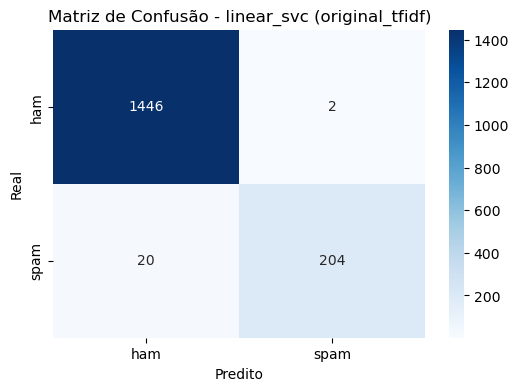

Modelo: naive_bayes
  Acurácia: 0.9635
  Precisão: 0.9650
  Recall: 0.9635
  F1-Score: 0.9610
  Matriz de Confusão:
[[1448    0]
 [  61  163]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.73      0.84       224

    accuracy                           0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672



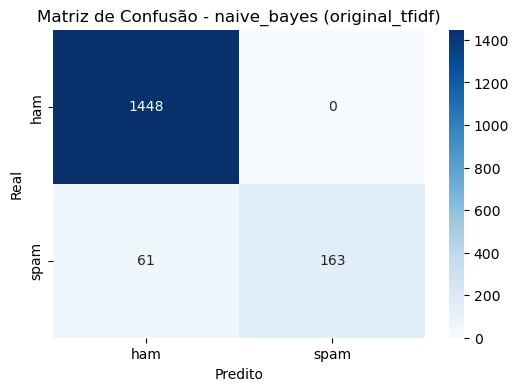

Modelo: random_forest
  Acurácia: 0.9779
  Precisão: 0.9784
  Recall: 0.9779
  F1-Score: 0.9770
  Matriz de Confusão:
[[1448    0]
 [  37  187]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.83      0.91       224

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



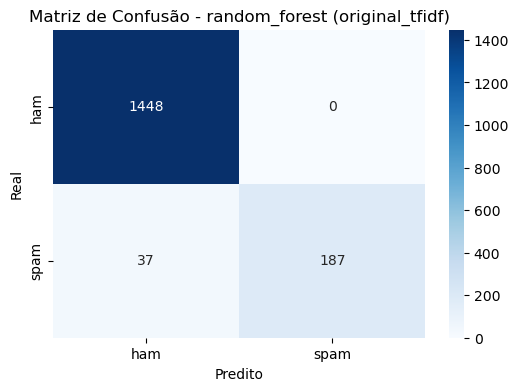

Modelo: logistic_regression
  Acurácia: 0.9671
  Precisão: 0.9678
  Recall: 0.9671
  F1-Score: 0.9653
  Matriz de Confusão:
[[1446    2]
 [  53  171]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       0.99      0.76      0.86       224

    accuracy                           0.97      1672
   macro avg       0.98      0.88      0.92      1672
weighted avg       0.97      0.97      0.97      1672



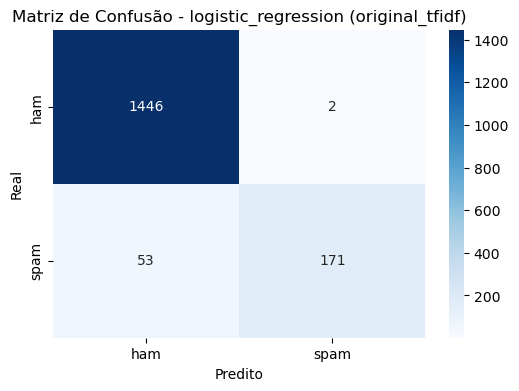


--- Avaliando modelos com dados: sw_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9856
  Precisão: 0.9857
  Recall: 0.9856
  F1-Score: 0.9854
  Matriz de Confusão:
[[1446    2]
 [  22  202]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.90      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



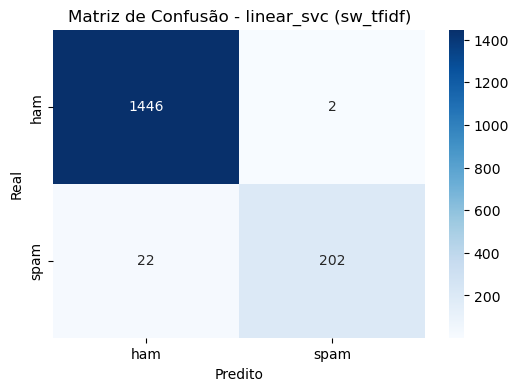

Modelo: naive_bayes
  Acurácia: 0.9635
  Precisão: 0.9650
  Recall: 0.9635
  F1-Score: 0.9610
  Matriz de Confusão:
[[1448    0]
 [  61  163]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.73      0.84       224

    accuracy                           0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672



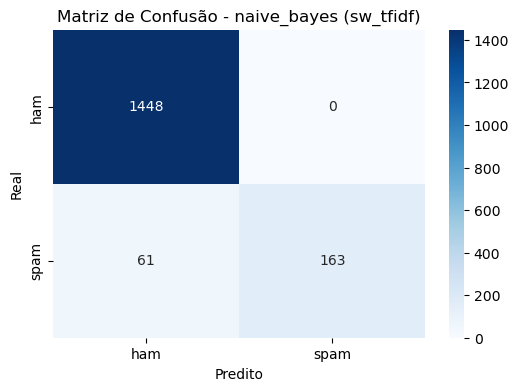

Modelo: random_forest
  Acurácia: 0.9761
  Precisão: 0.9767
  Recall: 0.9761
  F1-Score: 0.9751
  Matriz de Confusão:
[[1448    0]
 [  40  184]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       1.00      0.82      0.90       224

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.98      1672



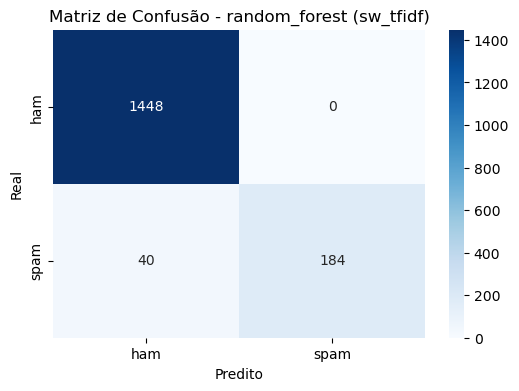

Modelo: logistic_regression
  Acurácia: 0.9653
  Precisão: 0.9659
  Recall: 0.9653
  F1-Score: 0.9633
  Matriz de Confusão:
[[1445    3]
 [  55  169]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       0.98      0.75      0.85       224

    accuracy                           0.97      1672
   macro avg       0.97      0.88      0.92      1672
weighted avg       0.97      0.97      0.96      1672



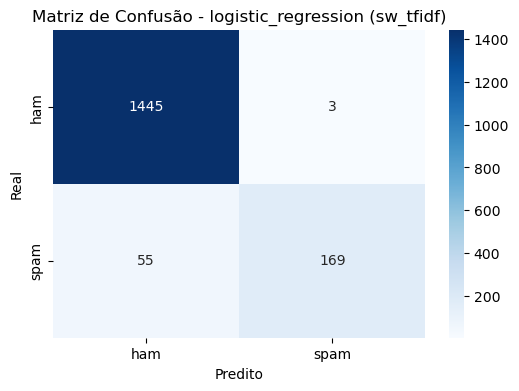


--- Avaliando modelos com dados: stem_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9868
  Precisão: 0.9870
  Recall: 0.9868
  F1-Score: 0.9866
  Matriz de Confusão:
[[1448    0]
 [  22  202]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       1.00      0.90      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



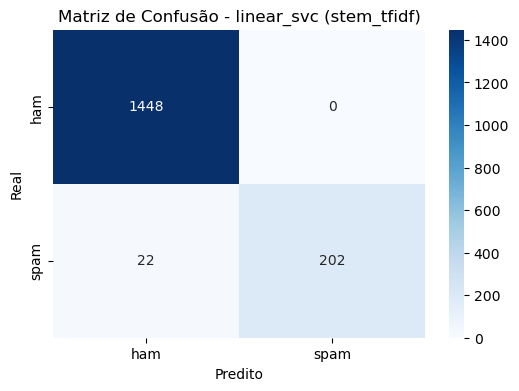

Modelo: naive_bayes
  Acurácia: 0.9635
  Precisão: 0.9647
  Recall: 0.9635
  F1-Score: 0.9611
  Matriz de Confusão:
[[1447    1]
 [  60  164]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       0.99      0.73      0.84       224

    accuracy                           0.96      1672
   macro avg       0.98      0.87      0.91      1672
weighted avg       0.96      0.96      0.96      1672



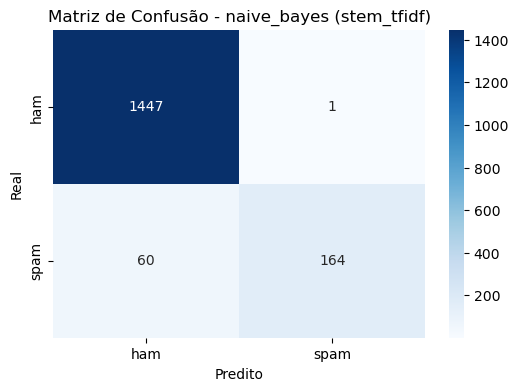

Modelo: random_forest
  Acurácia: 0.9767
  Precisão: 0.9773
  Recall: 0.9767
  F1-Score: 0.9757
  Matriz de Confusão:
[[1448    0]
 [  39  185]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       1.00      0.83      0.90       224

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.95      1672
weighted avg       0.98      0.98      0.98      1672



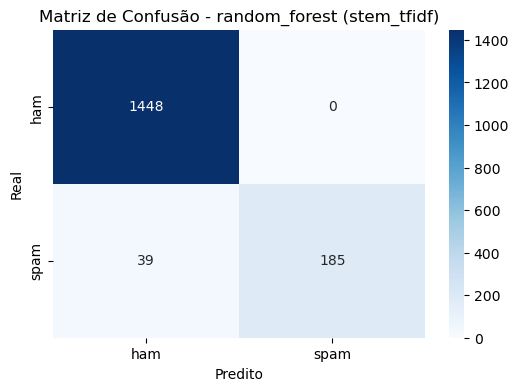

Modelo: logistic_regression
  Acurácia: 0.9647
  Precisão: 0.9649
  Recall: 0.9647
  F1-Score: 0.9628
  Matriz de Confusão:
[[1443    5]
 [  54  170]]
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       0.97      0.76      0.85       224

    accuracy                           0.96      1672
   macro avg       0.97      0.88      0.92      1672
weighted avg       0.96      0.96      0.96      1672



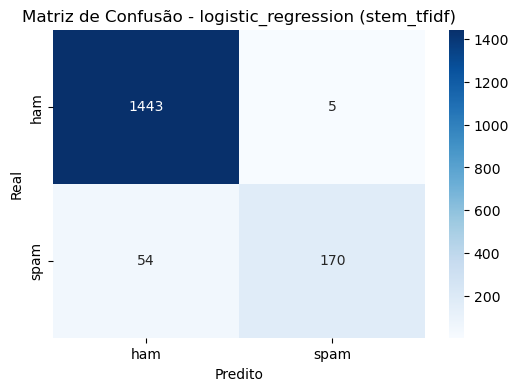


--- Avaliando modelos com dados: original_count ---
Modelo: linear_svc
  Acurácia: 0.9886
  Precisão: 0.9887
  Recall: 0.9886
  F1-Score: 0.9884
  Matriz de Confusão:
[[1447    1]
 [  18  206]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       1.00      0.92      0.96       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



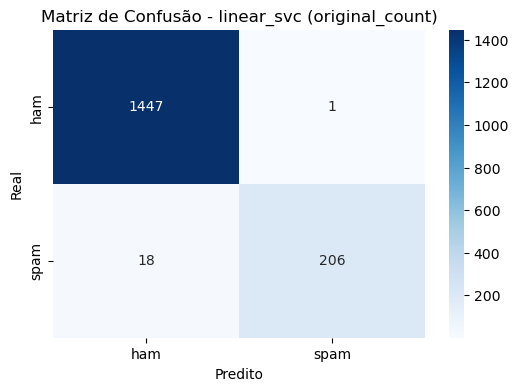

Modelo: naive_bayes
  Acurácia: 0.9803
  Precisão: 0.9808
  Recall: 0.9803
  F1-Score: 0.9805
  Matriz de Confusão:
[[1426   22]
 [  11  213]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.91      0.95      0.93       224

    accuracy                           0.98      1672
   macro avg       0.95      0.97      0.96      1672
weighted avg       0.98      0.98      0.98      1672



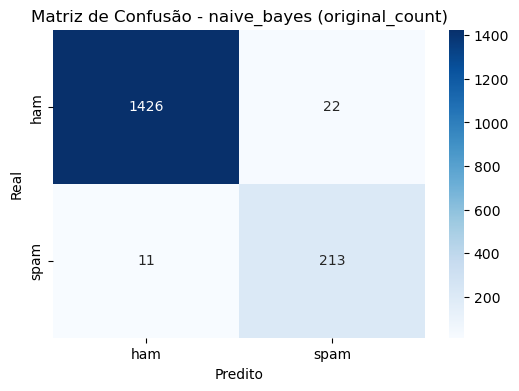

Modelo: random_forest
  Acurácia: 0.9755
  Precisão: 0.9762
  Recall: 0.9755
  F1-Score: 0.9744
  Matriz de Confusão:
[[1448    0]
 [  41  183]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       1.00      0.82      0.90       224

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.97      1672



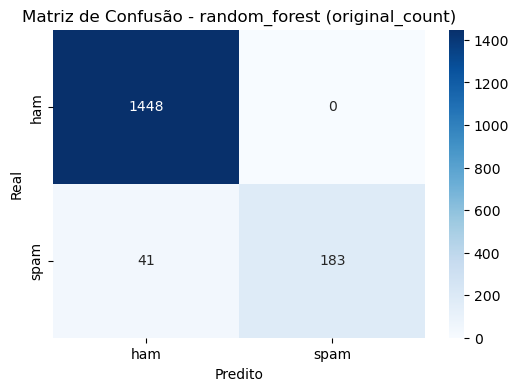

Modelo: logistic_regression
  Acurácia: 0.9874
  Precisão: 0.9874
  Recall: 0.9874
  F1-Score: 0.9873
  Matriz de Confusão:
[[1445    3]
 [  18  206]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.92      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



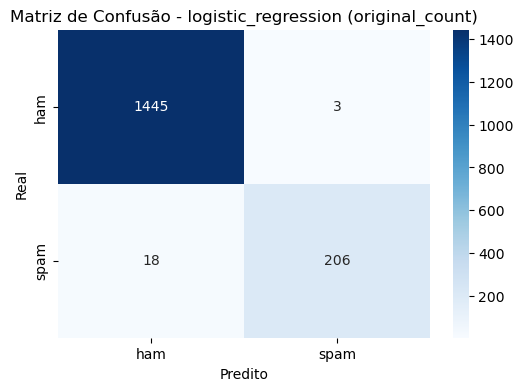


--- Avaliando modelos com dados: sw_count ---
Modelo: linear_svc
  Acurácia: 0.9874
  Precisão: 0.9875
  Recall: 0.9874
  F1-Score: 0.9872
  Matriz de Confusão:
[[1446    2]
 [  19  205]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.92      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



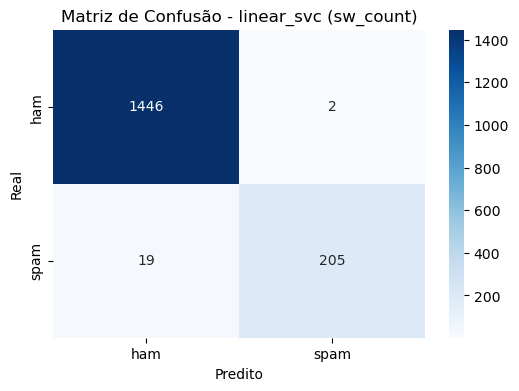

Modelo: naive_bayes
  Acurácia: 0.9785
  Precisão: 0.9794
  Recall: 0.9785
  F1-Score: 0.9788
  Matriz de Confusão:
[[1422   26]
 [  10  214]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.89      0.96      0.92       224

    accuracy                           0.98      1672
   macro avg       0.94      0.97      0.95      1672
weighted avg       0.98      0.98      0.98      1672



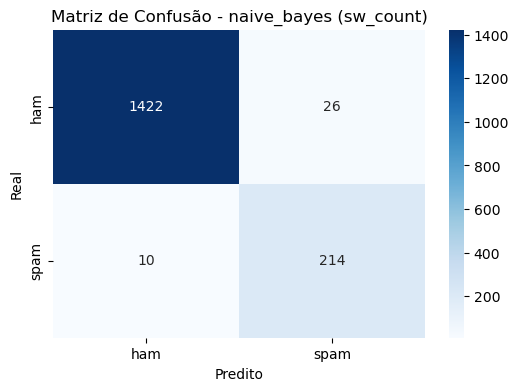

Modelo: random_forest
  Acurácia: 0.9731
  Precisão: 0.9739
  Recall: 0.9731
  F1-Score: 0.9718
  Matriz de Confusão:
[[1448    0]
 [  45  179]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1448
        spam       1.00      0.80      0.89       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



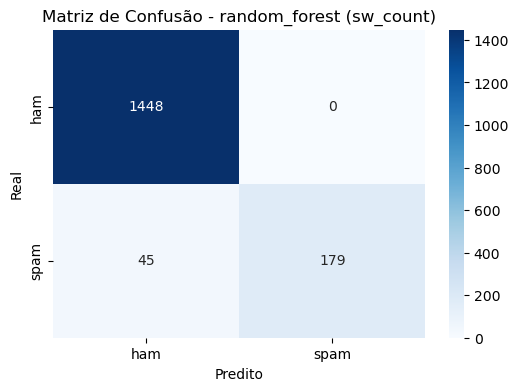

Modelo: logistic_regression
  Acurácia: 0.9856
  Precisão: 0.9856
  Recall: 0.9856
  F1-Score: 0.9854
  Matriz de Confusão:
[[1445    3]
 [  21  203]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.91      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



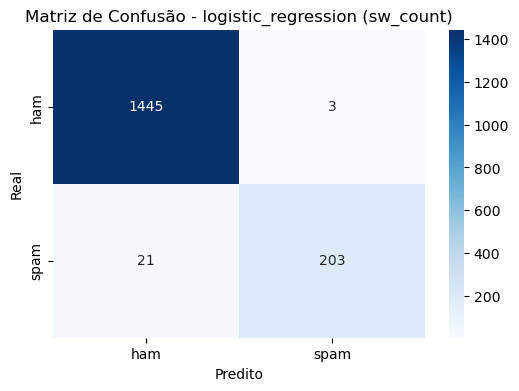


--- Avaliando modelos com dados: stem_count ---
Modelo: linear_svc
  Acurácia: 0.9862
  Precisão: 0.9863
  Recall: 0.9862
  F1-Score: 0.9860
  Matriz de Confusão:
[[1446    2]
 [  21  203]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.91      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



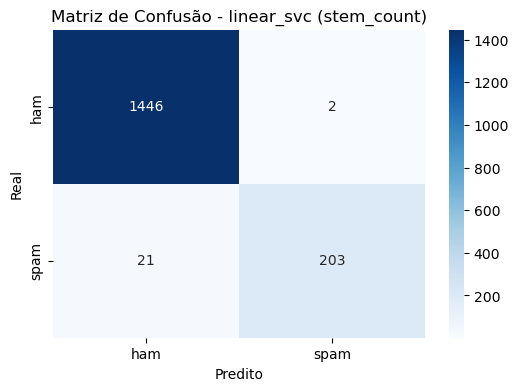

Modelo: naive_bayes
  Acurácia: 0.9773
  Precisão: 0.9784
  Recall: 0.9773
  F1-Score: 0.9776
  Matriz de Confusão:
[[1420   28]
 [  10  214]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.88      0.96      0.92       224

    accuracy                           0.98      1672
   macro avg       0.94      0.97      0.95      1672
weighted avg       0.98      0.98      0.98      1672



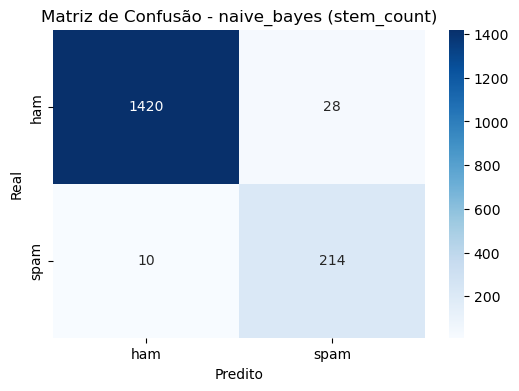

Modelo: random_forest
  Acurácia: 0.9755
  Precisão: 0.9762
  Recall: 0.9755
  F1-Score: 0.9744
  Matriz de Confusão:
[[1448    0]
 [  41  183]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       1.00      0.82      0.90       224

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.97      1672



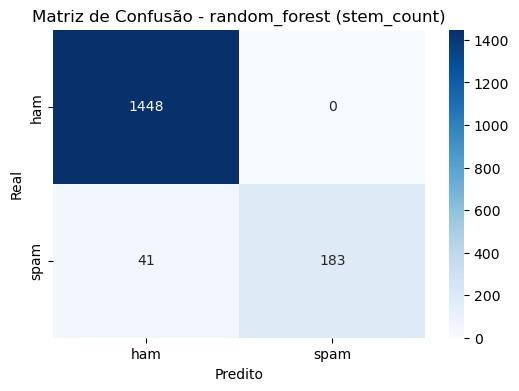

Modelo: logistic_regression
  Acurácia: 0.9850
  Precisão: 0.9851
  Recall: 0.9850
  F1-Score: 0.9848
  Matriz de Confusão:
[[1445    3]
 [  22  202]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.90      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.98      1672



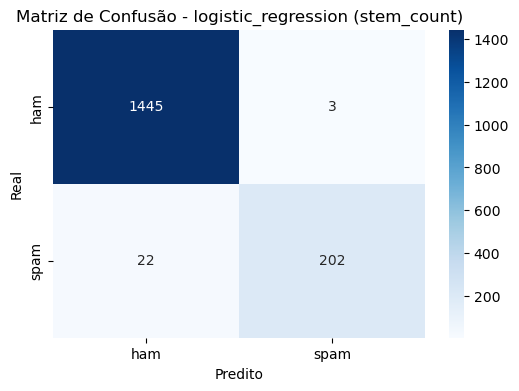


--- Avaliando modelos com dados: balanced_original_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9910
  Precisão: 0.9910
  Recall: 0.9910
  F1-Score: 0.9909
  Matriz de Confusão:
[[1446    2]
 [  13  211]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.94      0.97       224

    accuracy                           0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672



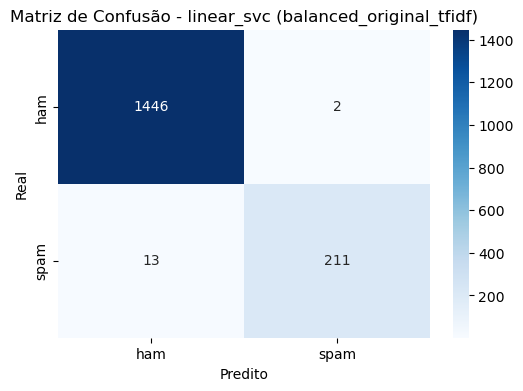

Modelo: naive_bayes
  Acurácia: 0.9779
  Precisão: 0.9793
  Recall: 0.9779
  F1-Score: 0.9783
  Matriz de Confusão:
[[1419   29]
 [   8  216]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.88      0.96      0.92       224

    accuracy                           0.98      1672
   macro avg       0.94      0.97      0.95      1672
weighted avg       0.98      0.98      0.98      1672



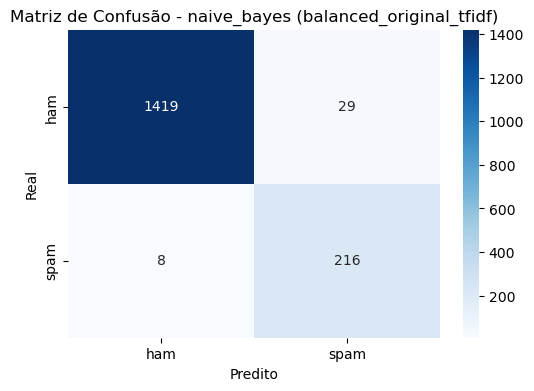

Modelo: random_forest
  Acurácia: 0.9833
  Precisão: 0.9836
  Recall: 0.9833
  F1-Score: 0.9828
  Matriz de Confusão:
[[1448    0]
 [  28  196]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.88      0.93       224

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



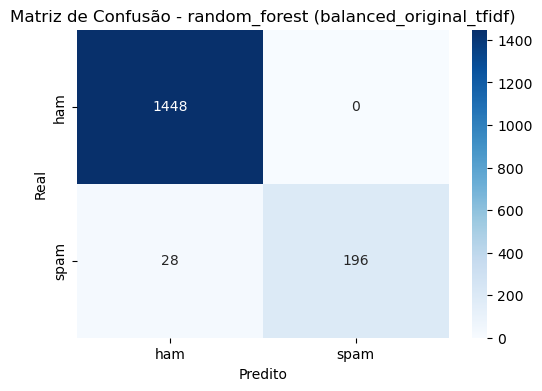

Modelo: logistic_regression
  Acurácia: 0.9839
  Precisão: 0.9838
  Recall: 0.9839
  F1-Score: 0.9838
  Matriz de Confusão:
[[1436   12]
 [  15  209]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.95      0.93      0.94       224

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.97      1672
weighted avg       0.98      0.98      0.98      1672



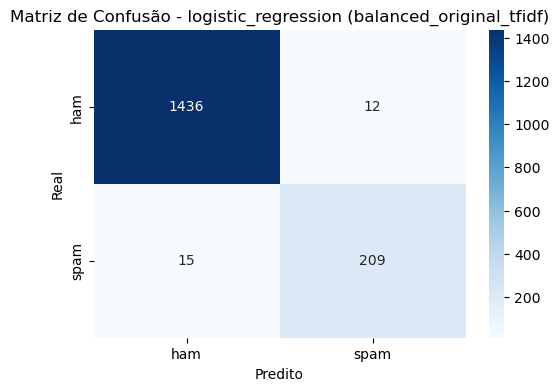


--- Avaliando modelos com dados: balanced_sw_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9886
  Precisão: 0.9886
  Recall: 0.9886
  F1-Score: 0.9885
  Matriz de Confusão:
[[1445    3]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.93      0.96       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



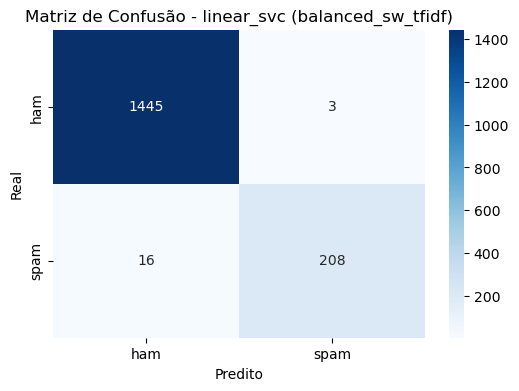

Modelo: naive_bayes
  Acurácia: 0.9767
  Precisão: 0.9783
  Recall: 0.9767
  F1-Score: 0.9772
  Matriz de Confusão:
[[1417   31]
 [   8  216]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.87      0.96      0.92       224

    accuracy                           0.98      1672
   macro avg       0.93      0.97      0.95      1672
weighted avg       0.98      0.98      0.98      1672



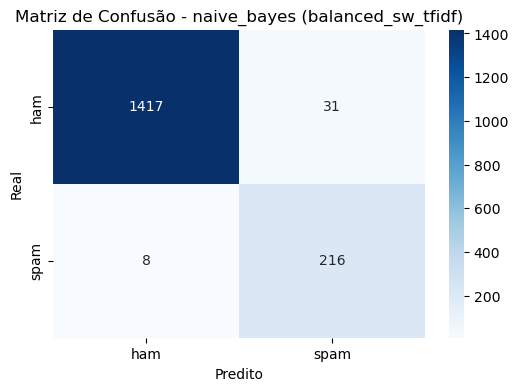

Modelo: random_forest
  Acurácia: 0.9815
  Precisão: 0.9818
  Recall: 0.9815
  F1-Score: 0.9809
  Matriz de Confusão:
[[1448    0]
 [  31  193]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.86      0.93       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672



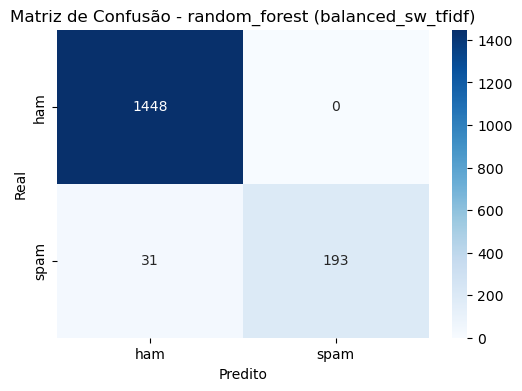

Modelo: logistic_regression
  Acurácia: 0.9850
  Precisão: 0.9849
  Recall: 0.9850
  F1-Score: 0.9849
  Matriz de Confusão:
[[1439    9]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.96      0.93      0.94       224

    accuracy                           0.99      1672
   macro avg       0.97      0.96      0.97      1672
weighted avg       0.98      0.99      0.98      1672



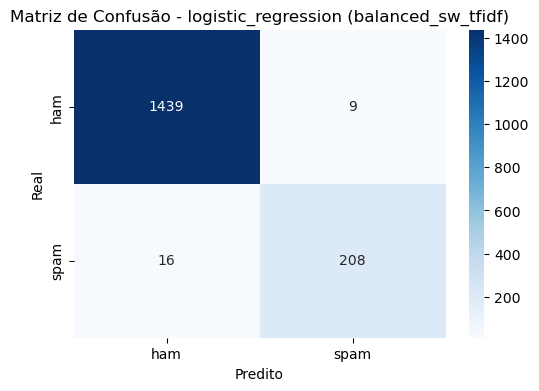


--- Avaliando modelos com dados: balanced_stem_tfidf ---
Modelo: linear_svc
  Acurácia: 0.9874
  Precisão: 0.9874
  Recall: 0.9874
  F1-Score: 0.9873
  Matriz de Confusão:
[[1443    5]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.98      0.93      0.95       224

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



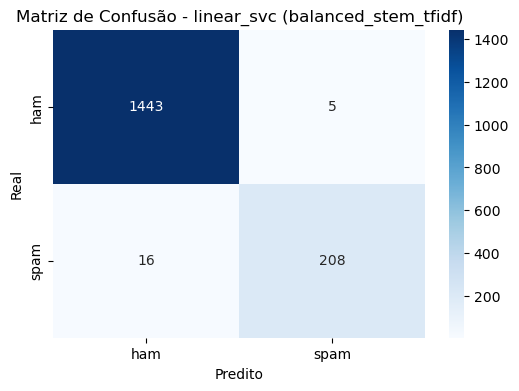

Modelo: naive_bayes
  Acurácia: 0.9713
  Precisão: 0.9739
  Recall: 0.9713
  F1-Score: 0.9720
  Matriz de Confusão:
[[1409   39]
 [   9  215]]
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      1448
        spam       0.85      0.96      0.90       224

    accuracy                           0.97      1672
   macro avg       0.92      0.97      0.94      1672
weighted avg       0.97      0.97      0.97      1672



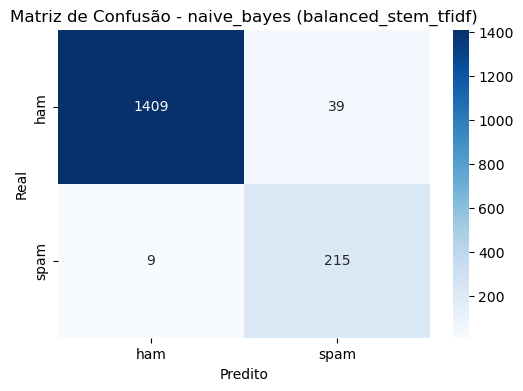

Modelo: random_forest
  Acurácia: 0.9803
  Precisão: 0.9807
  Recall: 0.9803
  F1-Score: 0.9796
  Matriz de Confusão:
[[1448    0]
 [  33  191]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.85      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



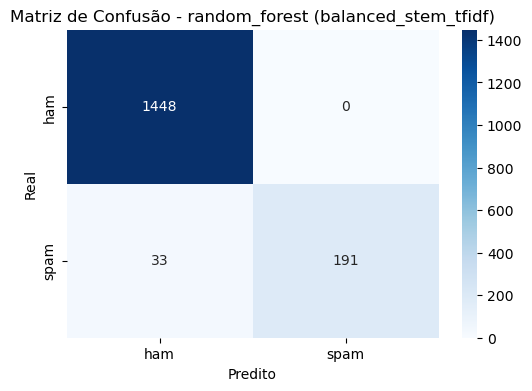

Modelo: logistic_regression
  Acurácia: 0.9833
  Precisão: 0.9831
  Recall: 0.9833
  F1-Score: 0.9832
  Matriz de Confusão:
[[1436   12]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.95      0.93      0.94       224

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



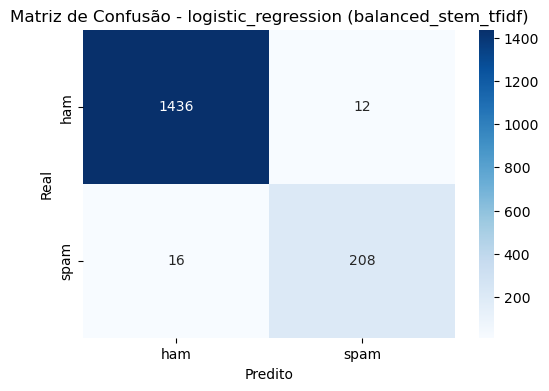


--- Avaliando modelos com dados: balanced_original_count ---
Modelo: linear_svc
  Acurácia: 0.9217
  Precisão: 0.9381
  Recall: 0.9217
  F1-Score: 0.9266
  Matriz de Confusão:
[[1341  107]
 [  24  200]]
              precision    recall  f1-score   support

         ham       0.98      0.93      0.95      1448
        spam       0.65      0.89      0.75       224

    accuracy                           0.92      1672
   macro avg       0.82      0.91      0.85      1672
weighted avg       0.94      0.92      0.93      1672



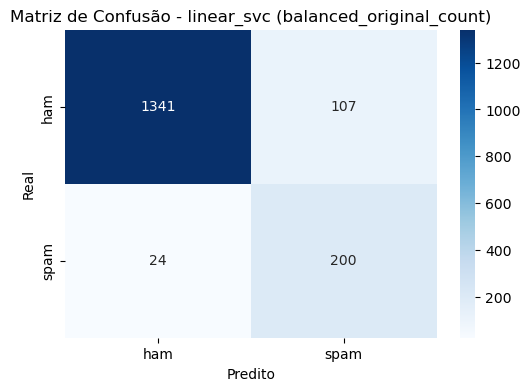

Modelo: naive_bayes
  Acurácia: 0.9767
  Precisão: 0.9780
  Recall: 0.9767
  F1-Score: 0.9771
  Matriz de Confusão:
[[1419   29]
 [  10  214]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1448
        spam       0.88      0.96      0.92       224

    accuracy                           0.98      1672
   macro avg       0.94      0.97      0.95      1672
weighted avg       0.98      0.98      0.98      1672



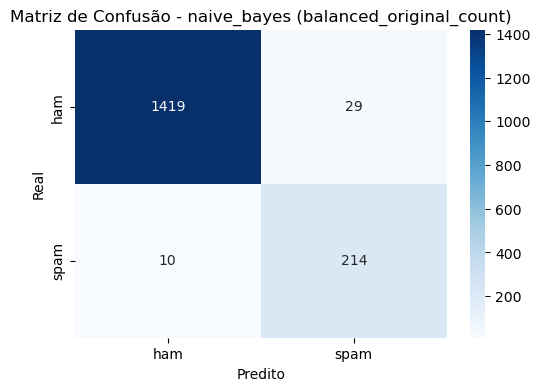

Modelo: random_forest
  Acurácia: 0.9330
  Precisão: 0.9445
  Recall: 0.9330
  F1-Score: 0.9365
  Matriz de Confusão:
[[1359   89]
 [  23  201]]
              precision    recall  f1-score   support

         ham       0.98      0.94      0.96      1448
        spam       0.69      0.90      0.78       224

    accuracy                           0.93      1672
   macro avg       0.84      0.92      0.87      1672
weighted avg       0.94      0.93      0.94      1672



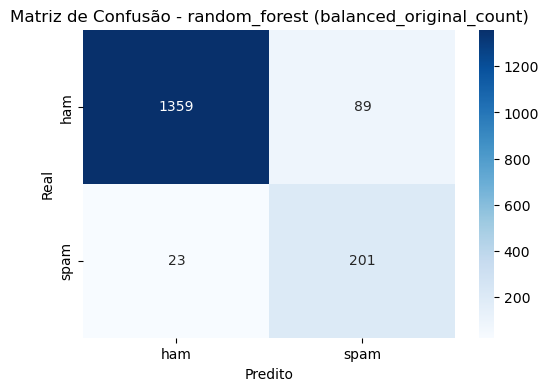

Modelo: logistic_regression
  Acurácia: 0.9258
  Precisão: 0.9445
  Recall: 0.9258
  F1-Score: 0.9310
  Matriz de Confusão:
[[1339  109]
 [  15  209]]
              precision    recall  f1-score   support

         ham       0.99      0.92      0.96      1448
        spam       0.66      0.93      0.77       224

    accuracy                           0.93      1672
   macro avg       0.82      0.93      0.86      1672
weighted avg       0.94      0.93      0.93      1672



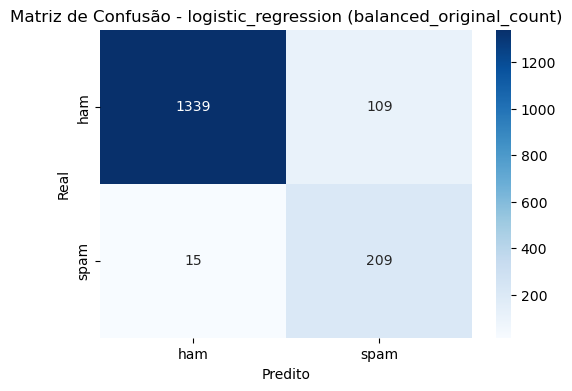


--- Avaliando modelos com dados: balanced_sw_count ---
Modelo: linear_svc
  Acurácia: 0.9211
  Precisão: 0.9364
  Recall: 0.9211
  F1-Score: 0.9258
  Matriz de Confusão:
[[1343  105]
 [  27  197]]
              precision    recall  f1-score   support

         ham       0.98      0.93      0.95      1448
        spam       0.65      0.88      0.75       224

    accuracy                           0.92      1672
   macro avg       0.82      0.90      0.85      1672
weighted avg       0.94      0.92      0.93      1672



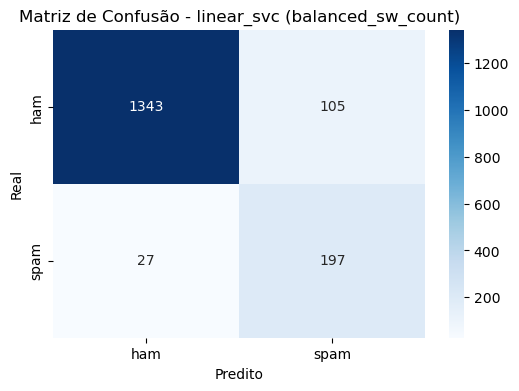

Modelo: naive_bayes
  Acurácia: 0.9731
  Precisão: 0.9749
  Recall: 0.9731
  F1-Score: 0.9736
  Matriz de Confusão:
[[1414   34]
 [  11  213]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1448
        spam       0.86      0.95      0.90       224

    accuracy                           0.97      1672
   macro avg       0.93      0.96      0.94      1672
weighted avg       0.97      0.97      0.97      1672



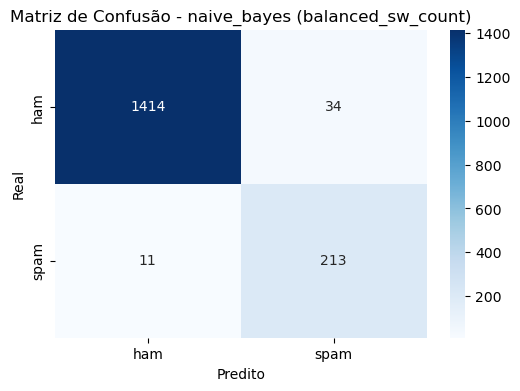

Modelo: random_forest
  Acurácia: 0.9324
  Precisão: 0.9455
  Recall: 0.9324
  F1-Score: 0.9363
  Matriz de Confusão:
[[1355   93]
 [  20  204]]
              precision    recall  f1-score   support

         ham       0.99      0.94      0.96      1448
        spam       0.69      0.91      0.78       224

    accuracy                           0.93      1672
   macro avg       0.84      0.92      0.87      1672
weighted avg       0.95      0.93      0.94      1672



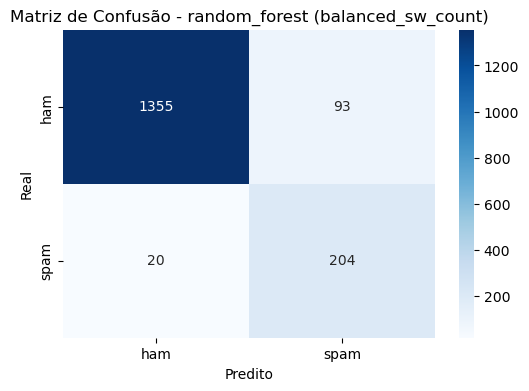

Modelo: logistic_regression
  Acurácia: 0.9264
  Precisão: 0.9443
  Recall: 0.9264
  F1-Score: 0.9315
  Matriz de Confusão:
[[1341  107]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      0.93      0.96      1448
        spam       0.66      0.93      0.77       224

    accuracy                           0.93      1672
   macro avg       0.82      0.93      0.86      1672
weighted avg       0.94      0.93      0.93      1672



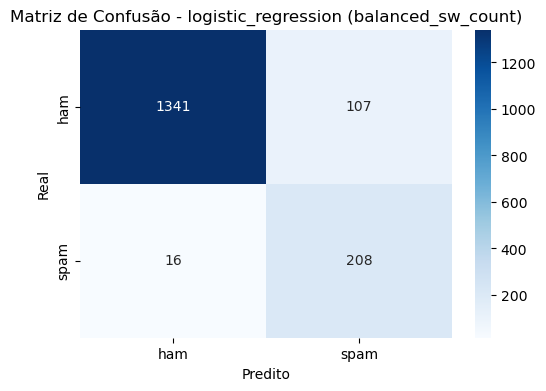


--- Avaliando modelos com dados: balanced_stem_count ---
Modelo: linear_svc
  Acurácia: 0.9258
  Precisão: 0.9411
  Recall: 0.9258
  F1-Score: 0.9304
  Matriz de Confusão:
[[1346  102]
 [  22  202]]
              precision    recall  f1-score   support

         ham       0.98      0.93      0.96      1448
        spam       0.66      0.90      0.77       224

    accuracy                           0.93      1672
   macro avg       0.82      0.92      0.86      1672
weighted avg       0.94      0.93      0.93      1672



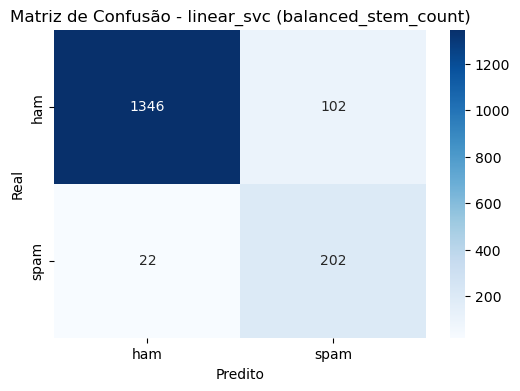

Modelo: naive_bayes
  Acurácia: 0.9731
  Precisão: 0.9745
  Recall: 0.9731
  F1-Score: 0.9735
  Matriz de Confusão:
[[1416   32]
 [  13  211]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1448
        spam       0.87      0.94      0.90       224

    accuracy                           0.97      1672
   macro avg       0.93      0.96      0.94      1672
weighted avg       0.97      0.97      0.97      1672



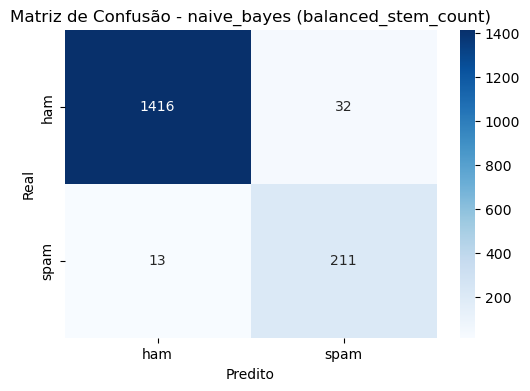

Modelo: random_forest
  Acurácia: 0.9432
  Precisão: 0.9512
  Recall: 0.9432
  F1-Score: 0.9457
  Matriz de Confusão:
[[1374   74]
 [  21  203]]
              precision    recall  f1-score   support

         ham       0.98      0.95      0.97      1448
        spam       0.73      0.91      0.81       224

    accuracy                           0.94      1672
   macro avg       0.86      0.93      0.89      1672
weighted avg       0.95      0.94      0.95      1672



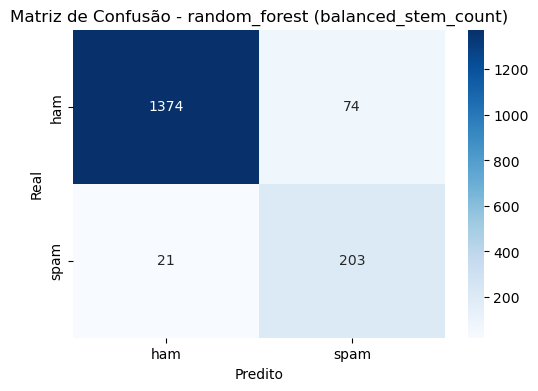

Modelo: logistic_regression
  Acurácia: 0.9336
  Precisão: 0.9479
  Recall: 0.9336
  F1-Score: 0.9377
  Matriz de Confusão:
[[1353   95]
 [  16  208]]
              precision    recall  f1-score   support

         ham       0.99      0.93      0.96      1448
        spam       0.69      0.93      0.79       224

    accuracy                           0.93      1672
   macro avg       0.84      0.93      0.87      1672
weighted avg       0.95      0.93      0.94      1672



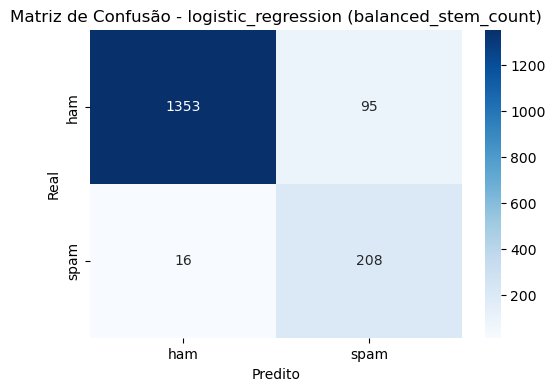


--- Justificativa da Métrica Principal ---
A escolha da métrica principal depende da natureza do problema e do balanceamento das classes.
Se o dataset apresentar um desbalanceamento significativo entre as classes (como pode ser o caso em detecção de spam, onde a maioria dos e-mails não é spam), a acurácia pode ser uma métrica enganosa.
Nesses cenários, o **F1-Score** é geralmente uma métrica mais adequada.
O F1-Score é a média harmônica da precisão e do recall, fornecendo uma medida equilibrada do desempenho do modelo, especialmente quando as classes são desiguais.
  - **Precisão** mede a proporção de exemplos classificados como positivos que são realmente positivos (evitando falsos positivos).
  - **Recall** mede a proporção de exemplos positivos reais que foram corretamente identificados pelo modelo (evitando falsos negativos).
Um alto F1-Score indica que o modelo tem um bom desempenho tanto na precisão quanto no recall.
Se o objetivo principal for minimizar falsos positivos (por ex

In [47]:
for data_name, (X_train, y_train, X_test, y_test) in data_sets.items():
    print(f"\n--- Avaliando modelos com dados: {data_name} ---")
    for model_name, model in model_names.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)

            print(f"Modelo: {model_name}")
            print(f"  Acurácia: {accuracy:.4f}")
            print(f"  Precisão: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print("  Matriz de Confusão:")
            print(cm)
            print(classification_report(y_test, y_pred))

            # Visualização da Matriz de Confusão
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=model.classes_, yticklabels=model.classes_)
            plt.xlabel('Predito')
            plt.ylabel('Real')
            plt.title(f'Matriz de Confusão - {model_name} ({data_name})')
            plt.show()

        except ValueError as e:
            print(f"Modelo: {model_name} não pôde ser treinado com estes dados devido a: {e}")
            print("Isso pode ocorrer com Naive Bayes e valores negativos em TF-IDF.")

print("\n--- Justificativa da Métrica Principal ---")
print("A escolha da métrica principal depende da natureza do problema e do balanceamento das classes.")
print("Se o dataset apresentar um desbalanceamento significativo entre as classes (como pode ser o caso em detecção de spam, onde a maioria dos e-mails não é spam), a acurácia pode ser uma métrica enganosa.")
print("Nesses cenários, o **F1-Score** é geralmente uma métrica mais adequada.")
print("O F1-Score é a média harmônica da precisão e do recall, fornecendo uma medida equilibrada do desempenho do modelo, especialmente quando as classes são desiguais.")
print("  - **Precisão** mede a proporção de exemplos classificados como positivos que são realmente positivos (evitando falsos positivos).")
print("  - **Recall** mede a proporção de exemplos positivos reais que foram corretamente identificados pelo modelo (evitando falsos negativos).")
print("Um alto F1-Score indica que o modelo tem um bom desempenho tanto na precisão quanto no recall.")
print("Se o objetivo principal for minimizar falsos positivos (por exemplo, classificar um e-mail importante como spam) ou falsos negativos (por exemplo, não detectar um e-mail de spam perigoso), a precisão ou o recall, respectivamente, podem ser considerados métricas mais importantes.")
print("No entanto, em muitos problemas de classificação, um bom equilíbrio entre precisão e recall (medido pelo F1-Score) é desejável.")

##### Justificar a escolha da métrica principal

Alto F1-Score Geral e para 'Spam': O Linear SVC consistentemente alcança F1-Scores elevados, tanto na média ponderada quanto especificamente para a classe 'spam', indicando um bom equilíbrio entre precisão e recall para ambas as classes.

# Passo 7: Otimização 

##### Ajustar hiperparâmetros com GridSearchCV ou RandomizedSearchCV

In [57]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [63]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator

print("--- Otimização de Hiperparâmetros com GridSearchCV ---")

# Assume que df_sms já está carregado e tem a coluna 'label'
if 'label' not in df_sms.columns:
    raise ValueError("A coluna 'label' não existe no DataFrame df_sms.")

# Definindo a variável alvo
y = df_sms['label']

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(df_sms['texto_original'], y, test_size=0.3, random_state=42)

# Criando um Transformer personalizado para SMOTE
class SMOTETRansformer(TransformerMixin, BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if y is not None:
            smote = SMOTE(random_state=self.random_state)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            return X_resampled
        return X

# Criando o Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTETRansformer(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])

# Definindo a grade de hiperparâmetros para o GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__dual': [False]  # dual=False é necessário com penalty='l1'
}

# Criando o GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

print("\nIniciando GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

print("\nMelhor F1-Score (weighted) no conjunto de validação:")
print(grid_search.best_score_)

print("\nResultados da avaliação no conjunto de teste com o melhor modelo:")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Otimização com RandomizedSearchCV (opcional) ---
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("\n--- Otimização de Hiperparâmetros com RandomizedSearchCV (Opcional) ---")

# Criando um novo Pipeline (com o Transformer SMOTE para consistência)
pipeline_random = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTETRansformer(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])

# Definindo a distribuição de hiperparâmetros para RandomizedSearchCV
param_distributions = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'clf__C': uniform(0.1, 100),
    'clf__penalty': ['l1', 'l2'],
    'clf__dual': [False]
}

# Criando o RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline_random, param_distributions, n_iter=10, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1, random_state=42)

print("\nIniciando RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados (RandomizedSearchCV):")
print(random_search.best_params_)

print("\nMelhor F1-Score (weighted) no conjunto de validação (RandomizedSearchCV):")
print(random_search.best_score_)

print("\nResultados da avaliação no conjunto de teste com o melhor modelo (RandomizedSearchCV):")
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)
print(classification_report(y_test, y_pred_random))

--- Otimização de Hiperparâmetros com GridSearchCV ---

Iniciando GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Melhores parâmetros encontrados:
{'clf__C': 100, 'clf__dual': False, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}

Melhor F1-Score (weighted) no conjunto de validação:
0.9854793712889413

Resultados da avaliação no conjunto de teste com o melhor modelo:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1448
        spam       0.99      0.96      0.97       224

    accuracy                           0.99      1672
   macro avg       0.99      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672


--- Otimização de Hiperparâmetros com RandomizedSearchCV (Opcional) ---

Iniciando RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Melhores parâmetros encontrados (RandomizedSearchCV):
{'clf__C': 33.4708611

In [71]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd

# Assume que df_sms já está carregado e tem as colunas 'label' e 'texto_original'
if 'label' not in df_sms.columns or 'texto_original' not in df_sms.columns:
    raise ValueError("O DataFrame df_sms deve conter as colunas 'label' e 'texto_original'.")

# Definindo a variável alvo
y = df_sms['label']

# Dividindo os dados para a avaliação do modelo base
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    df_sms['texto_original'], y, test_size=0.3, random_state=42
)

# --- Transformer personalizado para SMOTE ---
class SMOTETRansformer(TransformerMixin, BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if y is not None:
            smote = SMOTE(random_state=self.random_state)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            # Combine X_resampled with original features if needed
            # For text data, SMOTE is typically applied to the feature matrix directly
            return X_resampled
        return X

# --- Desempenho do Modelo Base (LinearSVC com TF-IDF e SMOTE) ---
print("\n--- Desempenho do Modelo Base (LinearSVC com TF-IDF e SMOTE) ---")
pipeline_base = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTETRansformer(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])
pipeline_base.fit(X_train_base, y_train_base)
y_pred_base = pipeline_base.predict(X_test_base)
f1_base = f1_score(y_test_base, y_pred_base, average='weighted')
report_base = classification_report(y_test_base, y_pred_base)
print(f"F1-Score (Weighted) no Teste (Modelo Base): {f1_base:.4f}")
print("Relatório de Classificação (Modelo Base):\n", report_base)

# --- Otimização de Hiperparâmetros com GridSearchCV ---
print("\n--- Otimização de Hiperparâmetros com GridSearchCV ---")

# Dividindo os dados para a otimização
X_train_optimized, X_test_optimized, y_train_optimized, y_test_optimized = train_test_split(
    df_sms['texto_original'], y, test_size=0.3, random_state=123
)

# Criando o Pipeline para otimização
pipeline_optimized = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTETRansformer(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])

# Definindo a grade de hiperparâmetros para o GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__dual': [False]  # dual=False é necessário com penalty='l1'
}

# Criando o GridSearchCV
grid_search = GridSearchCV(pipeline_optimized, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

print("\nIniciando GridSearchCV...")
grid_search.fit(X_train_optimized, y_train_optimized)

print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

print("\nMelhor F1-Score (weighted) no conjunto de validação:")
print(grid_search.best_score_)

print("\n--- Desempenho do Modelo Otimizado (GridSearchCV) ---")
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test_optimized)
f1_optimized = f1_score(y_test_optimized, y_pred_optimized, average='weighted')
report_optimized = classification_report(y_test_optimized, y_pred_optimized)
print(f"F1-Score (Weighted) no Teste (Modelo Otimizado): {f1_optimized:.4f}")
print("Relatório de Classificação (Modelo Otimizado):\n", report_optimized)

# --- Comparação Direta ---
print("\n--- Comparação Direta do Desempenho ---")
print(f"F1-Score (Weighted) no Teste (Modelo Base):     {f1_base:.4f}")
print(f"F1-Score (Weighted) no Teste (Modelo Otimizado): {f1_optimized:.4f}")

# Você pode adicionar mais comparações de métricas aqui (precisão, recall, etc.)


--- Desempenho do Modelo Base (LinearSVC com TF-IDF e SMOTE) ---
F1-Score (Weighted) no Teste (Modelo Base): 0.9928
Relatório de Classificação (Modelo Base):
               precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1448
        spam       0.99      0.96      0.97       224

    accuracy                           0.99      1672
   macro avg       0.99      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672


--- Otimização de Hiperparâmetros com GridSearchCV ---

Iniciando GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Melhores parâmetros encontrados:
{'clf__C': 100, 'clf__dual': False, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False}

Melhor F1-Score (weighted) no conjunto de validação:
0.9857332097670323

--- Desempenho do Modelo Otimizado (GridSearchCV) ---
F1-Score (Weighted) no Teste (Modelo Otimizado): 0.9855
Relatório de Classificação (Modelo Ot